In [18]:
%load_ext autoreload
%autoreload 2
from notebook import *
# if get something about NUMEXPR_MAX_THREADS being set incorrectly, don't worry.  It's not a problem.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experience Intel's "Performance Cores" and "Efficient Cores"

Intel's 13th generation processors also incorporate the idea of "Single ISA, Heterogeneous Architectures" or say "big.Little" architecture. In Linux system, the CPU id of p-cores comes first and then the e-cores. 

In [19]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 183
model name	: 13th Gen Intel(R) Core(TM) i7-13700
stepping	: 1
microcode	: 0x112
cpu MHz		: 2100.000
cache size	: 30720 KB
physical id	: 0
siblings	: 24
core id		: 0
cpu cores	: 16
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 32
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid rdseed adx smap clflushopt clwb intel_pt sha_ni xsaveopt xsavec xge

We can use taskset to see what the performance look like!

## Random from OS

In [20]:
hist_size = 1000000000
! make fiddle.exe; make C_OPTS="-O3" build/histogram.so
! ./fiddle.exe -lib ./build/histogram.so --header 'config,' --preamble 'all,' --detail -f run_private2_histogram -s {hist_size} --threads 1 2 3 4 -o histogram_private2_locks.csv

make: 'fiddle.exe' is up to date.
make: 'build/histogram.so' is up to date.
registering function: run_unthreaded_histogram
registering function: run_threaded_histogram
registering function: run_fine_locks_histogram
registering function: run_private_histogram
registering function: run_private2_histogram
registering function: run_openmp_histogram
registering function: run_openmp_private_histogram
Dynamically registering run_fine_locks_histogram
Dynamically registering run_openmp_histogram
Dynamically registering run_openmp_private_histogram
Dynamically registering run_private2_histogram
Dynamically registering run_private_histogram
Dynamically registering run_threaded_histogram
Dynamically registering run_unthreaded_histogram
Execution started
sh: 1: /usr/sbin/changefreq: not found
sh: 1: /usr/sbin/changefreq: not found
Execution completed


,config,function,threads,size,arg1,arg2,arg3,IC,CPI,ET,L1_dcache_misses,L1_dcache_miss_rate,Cycles,speedup,Total IC,Total cache misses
0,all,run_private2_histogram,1,1000000000,1,1,1,38004741640,0.330831,2.426784,0,NaN,12573137886,1.000000,38004741640,0
1,all,run_private2_histogram,2,1000000000,1,1,1,38007372005,0.559459,2.076423,0,NaN,21263571394,1.168733,76014744010,0
2,all,run_private2_histogram,3,1000000000,1,1,1,38007101128,0.571687,1.630525,0,NaN,21728159440,1.488345,114021303384,0
3,all,run_private2_histogram,4,1000000000,1,1,1,38007438996,0.618265,1.356020,0,NaN,23498653410,1.789637,152029755984,0


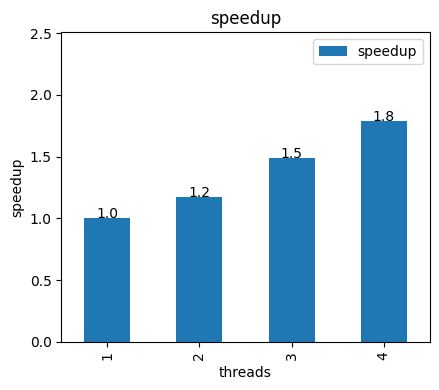

In [21]:
hist_data = render_csv("histogram_private2_locks.csv", columns=["config"]+hist_columns+["Cycles"])
#hist_data["ET"] = hist_data["ET"]/hist_data["thread"].apply(lambda x: 1 if x == 0 else x)
hist_data["speedup"] = hist_data.iloc[0]["ET"]/hist_data["ET"]
hist_data["Total IC"] = hist_data["IC"]*hist_data["threads"]
hist_data["Total cache misses"] = hist_data["L1_dcache_misses"]*hist_data["threads"]
display(hist_data)
plotPEBar(df=hist_data, what=[("threads", "speedup"), ])


## P-cores only

In [22]:
! taskset -c 0,2,4,6,8,10,12,14 ./fiddle.exe -lib ./build/histogram.so --detail --header 'config,' --preamble 'pcores_only,' -f run_private2_histogram -s {hist_size} --threads 1 2 3 4 -o histogram_private2_locks_pcores_only.csv

registering function: run_unthreaded_histogram
registering function: run_threaded_histogram
registering function: run_fine_locks_histogram
registering function: run_private_histogram
registering function: run_private2_histogram
registering function: run_openmp_histogram
registering function: run_openmp_private_histogram
Dynamically registering run_fine_locks_histogram
Dynamically registering run_openmp_histogram
Dynamically registering run_openmp_private_histogram
Dynamically registering run_private2_histogram
Dynamically registering run_private_histogram
Dynamically registering run_threaded_histogram
Dynamically registering run_unthreaded_histogram
Execution started
sh: 1: /usr/sbin/changefreq: not found
sh: 1: /usr/sbin/changefreq: not found
Execution completed


/nfshome/htseng/courses/CS203/demo/bigLittle/notebook.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(d)


,config,function,threads,size,arg1,arg2,arg3,IC,CPI,ET,L1_dcache_misses,L1_dcache_miss_rate,Cycles,speedup,Total IC,Total cache misses
0,all,run_private2_histogram,1,1000000000,1,1,1,38004741640,0.330831,2.426784,0,NaN,12573137886,1.000000,38004741640,0
1,all,run_private2_histogram,2,1000000000,1,1,1,38007372005,0.559459,2.076423,0,NaN,21263571394,1.168733,76014744010,0
2,all,run_private2_histogram,3,1000000000,1,1,1,38007101128,0.571687,1.630525,0,NaN,21728159440,1.488345,114021303384,0
3,all,run_private2_histogram,4,1000000000,1,1,1,38007438996,0.618265,1.356020,0,NaN,23498653410,1.789637,152029755984,0
0,pcores_only,run_private2_histogram,1,1000000000,1,1,1,38004906645,0.336515,2.469976,0,NaN,12789210228,0.982513,38004906645,0
1,pcores_only,run_private2_histogram,2,1000000000,1,1,1,38007465918,0.569882,2.132413,0,NaN,21659752443,1.138046,76014931836,0
2,pcores_only,run_private2_histogram,3,1000000000,1,1,1,38007347707,0.586696,1.650192,0,NaN,22298758698,1.470607,114022043121,0
3,pcores_only,run_private2_histogram,4,1000000000,1,1,1,38007406370,0.623533,1.383534,0,NaN,23698890242,1.754047,152029625480,0


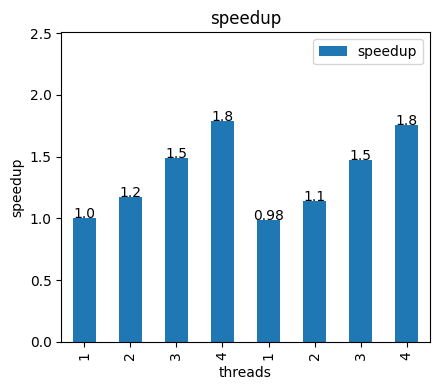

In [23]:
hist_data = render_csv(["histogram_private2_locks.csv", "histogram_private2_locks_pcores_only.csv"], columns=["config"]+hist_columns+["Cycles"])
#hist_data["ET"] = hist_data["ET"]/hist_data["thread"].apply(lambda x: 1 if x == 0 else x)
hist_data["speedup"] = hist_data.iloc[0]["ET"]/hist_data["ET"]
hist_data["Total IC"] = hist_data["IC"]*hist_data["threads"]
hist_data["Total cache misses"] = hist_data["L1_dcache_misses"]*hist_data["threads"]
display(hist_data)
#plotPE(df=hist_data, lines=True, what=[("threads", "speedup"), ])
plotPEBar(df=hist_data, what=[("threads", "speedup")])

## E-cores only

In [24]:
! cd ~/courses/CS203/demo/bigLittle;  taskset -c 16,17,18,19,20,21,22,23 ./fiddle.exe -lib ./build/histogram.so -M 3600 --detail  --header 'config,' --preamble 'ecores_only,'  -f run_private2_histogram -s {hist_size} --threads 1 2 3 4 -o histogram_private2_locks_ecores_only.csv

registering function: run_unthreaded_histogram
registering function: run_threaded_histogram
registering function: run_fine_locks_histogram
registering function: run_private_histogram
registering function: run_private2_histogram
registering function: run_openmp_histogram
registering function: run_openmp_private_histogram
Dynamically registering run_fine_locks_histogram
Dynamically registering run_openmp_histogram
Dynamically registering run_openmp_private_histogram
Dynamically registering run_private2_histogram
Dynamically registering run_private_histogram
Dynamically registering run_threaded_histogram
Dynamically registering run_unthreaded_histogram
Execution started
sh: 1: /usr/sbin/changefreq: not found
sh: 1: /usr/sbin/changefreq: not found
Execution completed


/nfshome/htseng/courses/CS203/demo/bigLittle/notebook.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(d)
/nfshome/htseng/courses/CS203/demo/bigLittle/notebook.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(d)


,config,function,threads,size,arg1,arg2,arg3,IC,CPI,ET,L1_dcache_misses,L1_dcache_miss_rate,Cycles,speedup,Total IC,Total cache misses
0,all,run_private2_histogram,1,1000000000,1,1,1,38004741640,0.330831,2.426784,0,NaN,12573137886,1.000000,38004741640,0
1,all,run_private2_histogram,2,1000000000,1,1,1,38007372005,0.559459,2.076423,0,NaN,21263571394,1.168733,76014744010,0
2,all,run_private2_histogram,3,1000000000,1,1,1,38007101128,0.571687,1.630525,0,NaN,21728159440,1.488345,114021303384,0
3,all,run_private2_histogram,4,1000000000,1,1,1,38007438996,0.618265,1.356020,0,NaN,23498653410,1.789637,152029755984,0
0,pcores_only,run_private2_histogram,1,1000000000,1,1,1,38004906645,0.336515,2.469976,0,NaN,12789210228,0.982513,38004906645,0
1,pcores_only,run_private2_histogram,2,1000000000,1,1,1,38007465918,0.569882,2.132413,0,NaN,21659752443,1.138046,76014931836,0
2,pcores_only,run_private2_histogram,3,1000000000,1,1,1,38007347707,0.586696,1.650192,0,NaN,22298758698,1.470607,114022043121,0
3,pcores_only,run_private2_histogram,4,1000000000,1,1,1,38007406370,0.623533,1.383534,0,NaN,23698890242,1.754047,152029625480,0
0,ecores_only,run_private2_histogram,1,1000000000,1,1,1,38003901381,0.278184,2.584637,0,NaN,10572065747,0.938926,38003901381,0
1,ecores_only,run_private2_histogram,2,1000000000,1,1,1,38007382118,0.561414,2.624241,0,NaN,21337893732,0.924757,76014764236,0


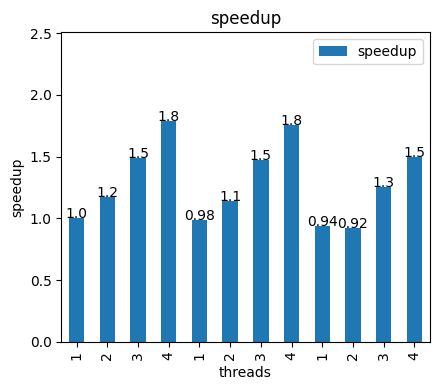

In [25]:
hist_data = render_csv(["histogram_private2_locks.csv", "histogram_private2_locks_pcores_only.csv", "histogram_private2_locks_ecores_only.csv"], columns=["config"]+hist_columns+["Cycles"])
#hist_data["ET"] = hist_data["ET"]/hist_data["thread"].apply(lambda x: 1 if x == 0 else x)
hist_data["speedup"] = hist_data.iloc[0]["ET"]/hist_data["ET"]
hist_data["Total IC"] = hist_data["IC"]*hist_data["threads"]
hist_data["Total cache misses"] = hist_data["L1_dcache_misses"]*hist_data["threads"]
display(hist_data)
#plotPE(df=hist_data, lines=True, what=[("threads", "speedup"), ])
plotPEBar(df=hist_data, what=[("threads", "speedup")])

## Half and half

In [26]:
! taskset -c 12,14,16,17 ./fiddle.exe -lib ./build/histogram.so -M 3600 --detail --header 'config,' --preamble 'half_and_half,' -f run_private2_histogram -s {hist_size} --threads 1 2 3 4 -o histogram_private2_locks_both.csv

registering function: run_unthreaded_histogram
registering function: run_threaded_histogram
registering function: run_fine_locks_histogram
registering function: run_private_histogram
registering function: run_private2_histogram
registering function: run_openmp_histogram
registering function: run_openmp_private_histogram
Dynamically registering run_fine_locks_histogram
Dynamically registering run_openmp_histogram
Dynamically registering run_openmp_private_histogram
Dynamically registering run_private2_histogram
Dynamically registering run_private_histogram
Dynamically registering run_threaded_histogram
Dynamically registering run_unthreaded_histogram
Execution started
sh: 1: /usr/sbin/changefreq: not found
sh: 1: /usr/sbin/changefreq: not found
Execution completed


,config,function,threads,size,arg1,arg2,arg3,IC,CPI,ET,L1_dcache_misses,L1_dcache_miss_rate,Cycles,speedup,Total IC,Total cache misses
0,half_and_half,run_private2_histogram,1,1000000000,1,1,1,38004443591,0.347510,2.595303,0,NaN,13206916571,1.000000,38004443591,0
1,half_and_half,run_private2_histogram,2,1000000000,1,1,1,38006879741,0.592756,2.216546,0,NaN,22528820240,1.170877,76013759482,0
2,half_and_half,run_private2_histogram,3,1000000000,1,1,1,38006982875,0.580331,1.784346,0,NaN,22056622255,1.454484,114020948625,0
3,half_and_half,run_private2_histogram,4,1000000000,1,1,1,38006180444,0.506388,1.592510,0,NaN,19245886634,1.629693,152024721776,0


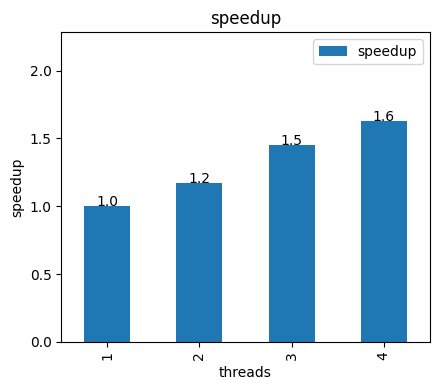

In [27]:
hist_data = render_csv("histogram_private2_locks_both.csv", columns=["config"]+hist_columns+["Cycles"])
#hist_data["ET"] = hist_data["ET"]/hist_data["thread"].apply(lambda x: 1 if x == 0 else x)
hist_data["speedup"] = hist_data.iloc[0]["ET"]/hist_data["ET"]
hist_data["Total IC"] = hist_data["IC"]*hist_data["threads"]
hist_data["Total cache misses"] = hist_data["L1_dcache_misses"]*hist_data["threads"]
display(hist_data)
plotPEBar(df=hist_data, what=[("threads", "speedup"), ])

/nfshome/htseng/courses/CS203/demo/bigLittle/notebook.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(d)
/nfshome/htseng/courses/CS203/demo/bigLittle/notebook.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(d)


,function,threads,size,arg1,arg2,arg3,IC,CPI,ET,L1_dcache_misses,L1_dcache_miss_rate,Cycles,speedup,Total IC,Total cache misses
0,run_private2_histogram,1,1000000000,1,1,1,38003823535,0.329597,2.666177,0,NaN,12525963726,1.000000,38003823535,0
1,run_private2_histogram,2,1000000000,1,1,1,38006708066,0.532686,2.232059,0,NaN,20245653003,1.194492,76013416132,0
2,run_private2_histogram,3,1000000000,1,1,1,38007178061,0.557898,1.896063,0,NaN,21204119112,1.406165,114021534183,0
3,run_private2_histogram,4,1000000000,1,1,1,38007528807,0.580830,1.678547,0,NaN,22075926998,1.588384,152030115228,0
0,run_private2_histogram,1,1000000000,1,1,1,38004061481,0.330198,2.633299,0,NaN,12548852058,1.012485,38004061481,0
1,run_private2_histogram,2,1000000000,1,1,1,38007174457,0.566598,2.381151,0,NaN,21534784616,1.119701,76014348914,0
2,run_private2_histogram,3,1000000000,1,1,1,38007540087,0.603134,1.947623,0,NaN,22923641747,1.368939,114022620261,0
3,run_private2_histogram,4,1000000000,1,1,1,38007724614,0.612161,1.637780,0,NaN,23266828212,1.627921,152030898456,0
0,run_private2_histogram,1,1000000000,1,1,1,38004017285,0.277008,2.826258,0,NaN,10527425315,0.943359,38004017285,0
1,run_private2_histogram,2,1000000000,1,1,1,38008036382,0.544267,2.793824,0,NaN,20686513583,0.954311,76016072764,0


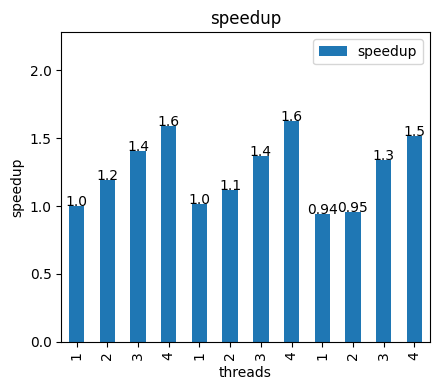

In [14]:
hist_data = render_csv(["histogram_private2_locks_both.csv", "histogram_private2_locks_pcores_only.csv", "histogram_private2_locks_ecores_only.csv"], columns=hist_columns+["Cycles"])
#hist_data["ET"] = hist_data["ET"]/hist_data["thread"].apply(lambda x: 1 if x == 0 else x)
hist_data["speedup"] = hist_data.iloc[0]["ET"]/hist_data["ET"]
hist_data["Total IC"] = hist_data["IC"]*hist_data["threads"]
hist_data["Total cache misses"] = hist_data["L1_dcache_misses"]*hist_data["threads"]
display(hist_data)
#plotPE(df=hist_data, lines=True, what=[("threads", "speedup"), ])
plotPEBar(df=hist_data, what=[("threads", "speedup")])